In [28]:
%pylab inline
from astropy.io import fits
import glob
import pandas as pd
from pandas import DataFrame
from scipy.interpolate import interp1d
from nirspec import divspec, gluespec
from spec_utils import vgeo
import pdb as pdb
import astropy
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astroquery.hitran import Hitran
from flux_calculator import extract_hitran_data, calc_fluxes, extract_vup, make_rotation_diagram
import numpy
from slabspec import extract_hitran_data

Populating the interactive namespace from numpy and matplotlib


In [29]:
#12/13/2010 & 12/14/2010
hdulist20101213 = fits.open('/Users/hanna/Desktop/URSI/ABAUR_20101213_glue.fits')
data20101213 = hdulist20101213[1].data
#12/31/2012,01/01/2013 & 01/03/2013
hdulist20121231 = fits.open('/Users/hanna/Desktop/URSI/ABAUR_20121231_glue.fits')
data20121231 = hdulist20121231[1].data
#12/23/2013 & 12/24/2013
hdulist20131223 = fits.open('/Users/hanna/Desktop/URSI/ABAUR_20131223_glue.fits')
data20131223 = hdulist20131223[1].data

In [30]:
#Telluric Cutoff
no = 0.60
from astropy.table import Table
t = Table.read('/Users/hanna/Desktop/URSI/ABAUR_20101213_glue.fits')
df1213 = t.to_pandas()
df1213 = DataFrame(df1213, columns = ['wave', 'div', 'src', 'std'])
df1213.loc[df1213['std'] >0, 'std'] = (df1213['std']/1.302589514146253) #normalize
df1213.loc[df1213['std'] <no, 'div'] = None

t = Table.read('/Users/hanna/Desktop/URSI/ABAUR_20121231_glue.fits')
df1231 = t.to_pandas()
df1231 = DataFrame(df1231, columns = ['wave', 'div', 'src', 'std'])
df1231.loc[df1231['std'] >0, 'std'] = (df1231['std']/1.3036475482894394) #normalize
df1231.loc[df1231['std'] <no, 'div'] = None

t = Table.read('/Users/hanna/Desktop/URSI/ABAUR_20131223_glue.fits')
df1223 = t.to_pandas()
df1223 = DataFrame(df1223, columns = ['wave', 'div', 'src', 'std'])
df1223.loc[df1223['std'] >0, 'std'] = (df1223['std']/1.2383725618468646) #normalize
df1223.loc[df1223['std'] <no, 'div'] = None


**Doppler Shift Equation:**
$\Delta$$\gamma$ = (v*$\gamma$)/c

In [31]:
#Doppler Shift
c = 3*10**5 #km/s

mydate1213=Time('2010-12-13T00:00:00.0', format='isot', scale='utc')
mycoord1213=SkyCoord('4h55m45.85s', '+30d34m02.7s', frame='icrs')
mydate1231=Time('2012-12-31T00:00:00.0', format='isot', scale='utc')
mycoord1231=SkyCoord('4h56m34.65s', '+30d34m08.3s', frame='icrs')
mycoord1223=SkyCoord('4h56m38.77s', '+30d34m12.0s', frame='icrs')
mydate1223=Time('2013-12-23T00:00:00.0', format='isot', scale='utc')

#Calculate the heliocentric velocity (Earth-induced + intrinsic)
myv1213=vgeo(mydate1213, mycoord1213, vhel=-7.93)
myv1231=vgeo(mydate1231, mycoord1231, vhel=-7.93)
myv1223=vgeo(mydate1223, mycoord1223, vhel=-7.93)

#print(myv, ' km/s')
gamma1213 = 4.711
gamma1231 = 4.711 
gamma1223 = 4.647

delta_gamma1213 = (myv1213*gamma1213)/c
delta_gamma1231 = (myv1231*gamma1231)/c
delta_gamma1223 = (myv1223*gamma1223)/c

df1213.loc[df1213['wave']> 0, 'wave'] = (df1213['wave']+delta_gamma1213)
df1231.loc[df1231['wave']> 0, 'wave'] = (df1231['wave']+delta_gamma1231)
df1223.loc[df1223['wave']> 0, 'wave'] = (df1223['wave']+delta_gamma1223)

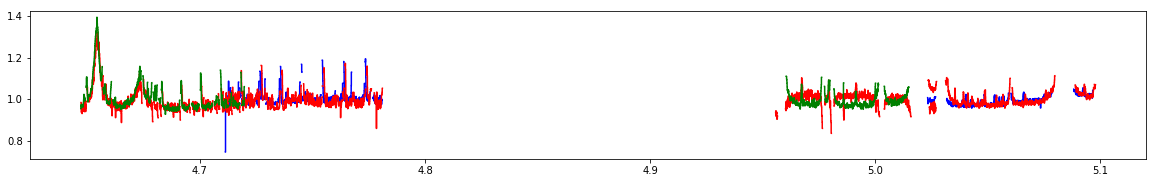

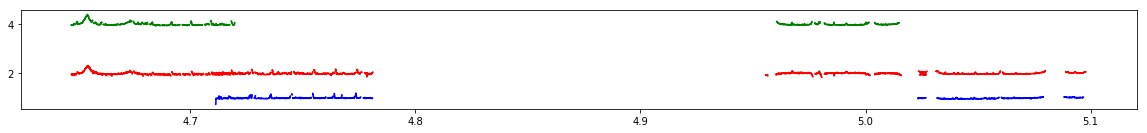

In [32]:
#Full Spectrum
fig =plt.figure(figsize(20,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')

fig = plt.figure(figsize(20,4))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div']+3,linestyle='steps-mid', color = 'green')




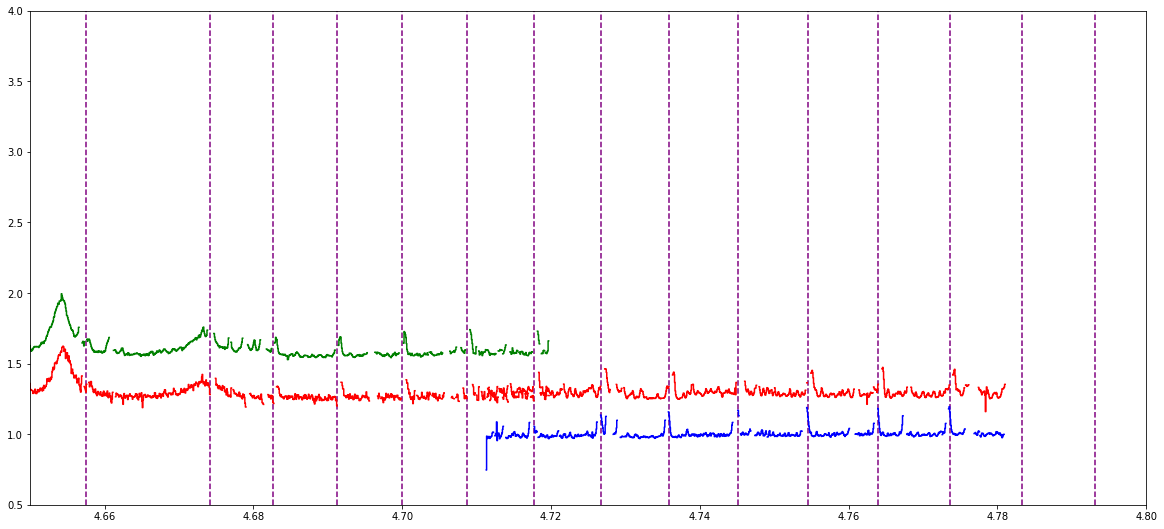

In [35]:
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)
HitCO = lineflux_data['wave']

fig =plt.figure(figsize(20,20))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

plt.plot()
for xc in HitCO:
    plt.axvline(x=xc, color='purple', linestyle='--')
    
plt.xlim([4.65, 4.8])
plt.ylim([0.5,4])
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+0.3,linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div']+0.6,linestyle='steps-mid', color = 'green')

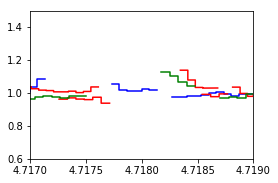

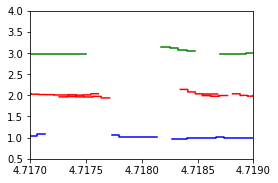

In [10]:
low1 = 4.717
high1 = 4.719

low2 = 4.70
high2 = 4.701

low3 = 4.708
high3 = 4.71

low4 = 4.713
high4 = 4.715

low5 = 4.725
high5 = 4.730

fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

plt.xlim([low1,high1])
plt.ylim([0.6,1.5])

plt.plot()
ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')


fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

plt.xlim([low1, high1])
plt.ylim([0.5,4])

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div']+2,linestyle='steps-mid', color = 'green')


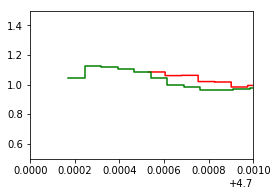

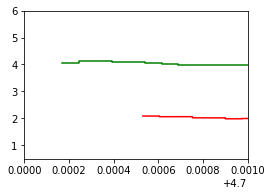

In [11]:
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

plt.xlim([low2, high2])
plt.ylim([0.5,1.5])

ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')

fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)

plt.xlim([low2, high2])
plt.ylim([0.5,6])

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df1223['wave'],df1223['div']+3,linestyle='steps-mid', color = 'green')


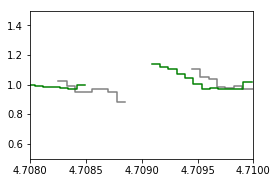

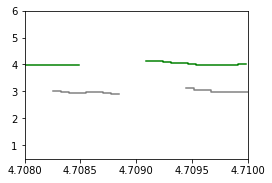

In [11]:
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low3, high3])
plt.ylim([0.5,1.5])

ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div'],linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')

fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low3, high3])
plt.ylim([0.5,6])

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div']+2,linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div']+3,linestyle='steps-mid', color = 'green')


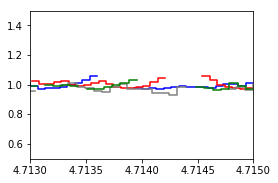

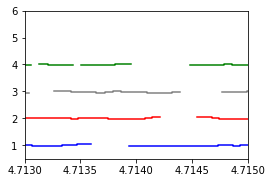

In [12]:
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low4, high4])
plt.ylim([0.5,1.5])

ax1.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div'],linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div'],linestyle='steps-mid', color = 'green')

fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

plt.xlim([low4, high4])
plt.ylim([0.5,6])

ax1.plot(df1213['wave'],df1213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1231['wave'],df1231['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(df0101['wave'],df0101['div']+2,linestyle='steps-mid', color = 'grey')
ax4.plot(df1223['wave'],df1223['div']+3,linestyle='steps-mid', color = 'green')

**Line Profiles**

In [ ]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data2010121314
wave=df1213['wave']
flux=df1213['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)

rot1213=make_rotation_diagram(out)

In [ ]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data201212310103
wave=df1231['wave']
flux=df1231['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)

rot1231=make_rotation_diagram(out)

molec_id local_iso_id     wn    ...        nu          eup_k      wave  
-------- ------------ --------- ... ---------------- --------- ---------
       5            1 1927.2478 ... 57777435000000.0  8968.453 5.1887465
       5            1  1932.545 ... 57936244000000.0  8719.708  5.174524
       5            1  1937.814 ... 58094200000000.0  8476.227 5.1604543
       5            1 1943.0544 ... 58251308000000.0   8238.02 5.1465364
       5            1 1948.2662 ... 58407554000000.0 8005.0957 5.1327686
       5            1 1953.4493 ... 58562940000000.0  7777.463 5.1191497
       5            1 1958.6035 ... 58717460000000.0   7555.13 5.1056786
       5            1 1963.7288 ... 58871110000000.0  7338.107  5.092353
       5            1 1968.8247 ... 59023880000000.0 7126.4014  5.079172
       5            1 1973.8915 ... 59175780000000.0 6920.0215 5.0661345
     ...          ...       ... ...              ...       ...       ...
       5            1 2131.6316 ... 63904710000000.

C:\Users\hanna\Anaconda\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


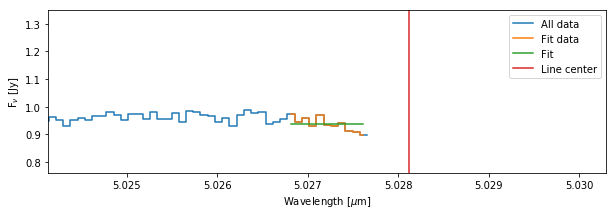

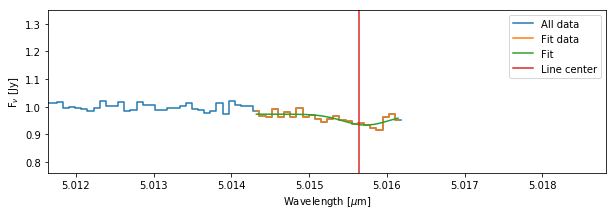

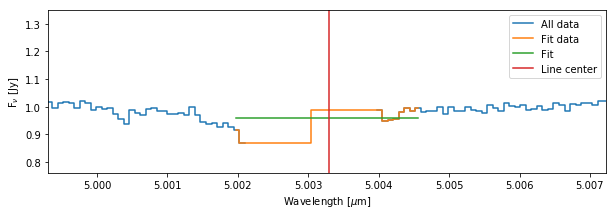

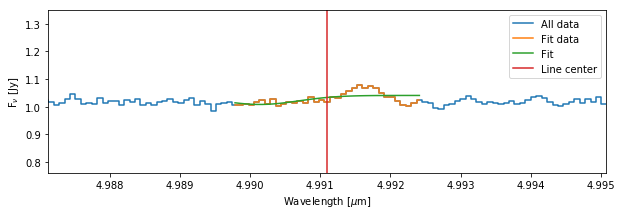

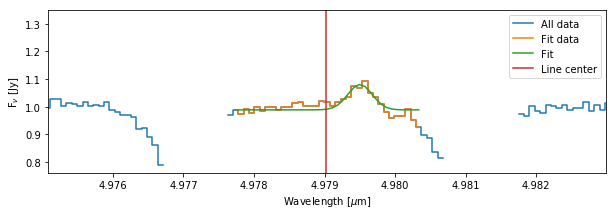

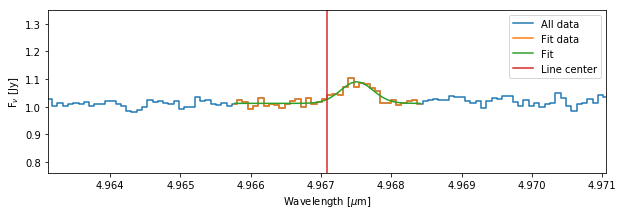

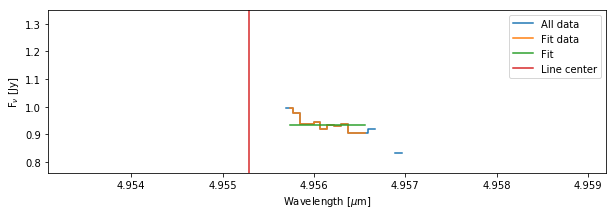

Not enough data near  4.94361005210669  microns. Skipping.
Not enough data near  4.93206620061765  microns. Skipping.
Not enough data near  4.9206515784641  microns. Skipping.
Not enough data near  4.90936475506299  microns. Skipping.
Not enough data near  4.898204776692286  microns. Skipping.
Not enough data near  4.887170689629956  microns. Skipping.
Not enough data near  4.87626106329295  microns. Skipping.
Not enough data near  4.865475420820251  microns. Skipping.
Not enough data near  4.854812808489826  microns. Skipping.
Not enough data near  4.844271795718625  microns. Skipping.
Not enough data near  4.833852382506649  microns. Skipping.
Not enough data near  4.823552184548815  microns. Skipping.
Not enough data near  4.8133716787061385  microns. Skipping.
Not enough data near  4.803309434395571  microns. Skipping.
Not enough data near  4.793363544173045  microns. Skipping.
Not enough data near  4.783535438621612  microns. Skipping.
Not enough data near  4.77382225657517  micro

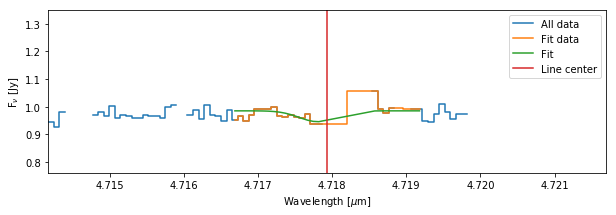

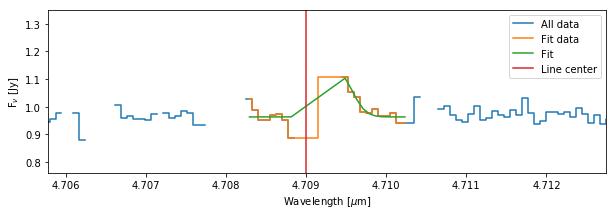

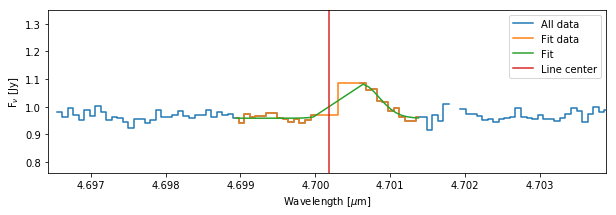

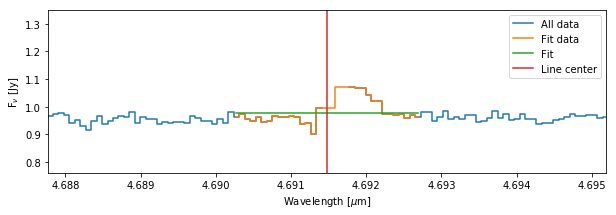

C:\Users\hanna\Desktop\URSI\flux_calculator\helpers.py:152: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(fitcovariance))


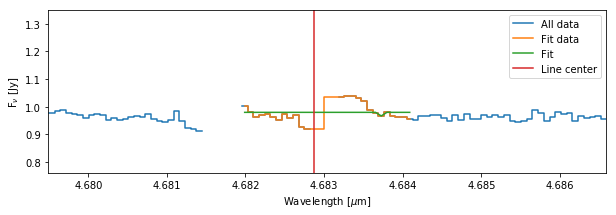

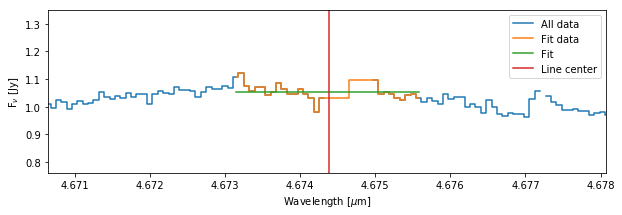

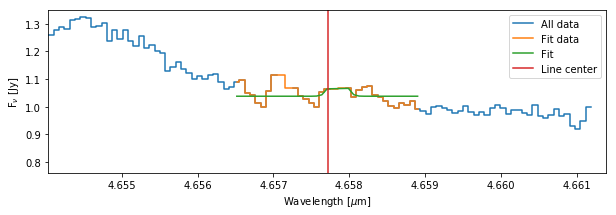

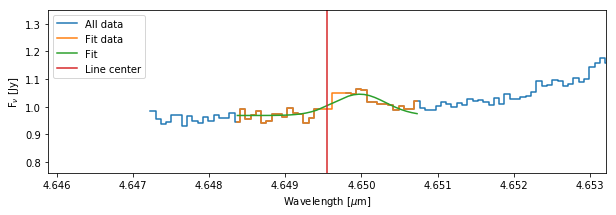

Not enough data near  4.641474250037329  microns. Skipping.
Not enough data near  4.633508286755587  microns. Skipping.
Not enough data near  4.625646279175457  microns. Skipping.
Not enough data near  4.617886796713888  microns. Skipping.
Not enough data near  4.610229362509864  microns. Skipping.
Not enough data near  4.602673976563386  microns. Skipping.


In [13]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)
print(lineflux_data)
#For Data2013010103
wave=df0101['wave']
flux=df0101['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)

rot0101=make_rotation_diagram(out)

In [ ]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data2013122324
wave=df1223['wave']
flux=df1223['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)

rot1223=make_rotation_diagram(out)

**Rotation Diagram**

F = A*$\sigma$*$\sqrt{2\pi}$*$\frac{c}{\lambda^2}$      Just use flux calc - how to fix for data['flux']

In [ ]:
fig =plt.figure(figsize(8,15))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)


plt.plot()
plt.ylim([-55,-51])
ax1.plot(rot1213['x'],rot1213['y'],'bo')
ax2.plot(rot1231['x'],rot1231['y'],'ro')
ax3.plot(rot0101['x'],rot0101['y'],'o')
ax4.plot(rot1223['x'],rot1223['y'],'o')